In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import glob
from pathlib import Path
from PIL import Image, ImageSequence
from tqdm import tqdm
import os
import os.path
from livecell_tracker import segment
from livecell_tracker import core
from livecell_tracker.core import datasets
from skimage import measure
from livecell_tracker.core import SingleCellTrajectory, SingleCellStatic

In [2]:
# model_type='cyto' or 'nuclei' or 'cyto2'
# model = models.Cellpose(gpu=True, model_type="cyto")
# pretrained_model_path = "../livecell_tracker/models/yuzhong_cyto2.pth"
pretrained_model_path = r"./notebook_results/train_log/detectron_train_output__ver0.0.2/model_final.pth"
# list of files
# PUT PATH TO YOUR FILES HERE!
# dir_path = Path(
#     r"D:/xing-vimentin-dic-pipeline/src/livecell_dev/cxa-data/june_2022_data_8bit_png/day0_Notreat_Group1_wellA1_RI_MIP_stitched"
# )
dir_path = "../cxa-data/june_2022_data_8bit_png/restart_day0_Group 1_wellA1_RI_MIP_stitched"
# dir_path = Path(
#     r"../cxa-data/june_2022_data_8bit_png/restart_day2_Group 1_wellA1_RI_MIP_stitched"
# )
# imgs = core.datasets.LiveCellImageDataset(dir_path, ext="tif")
# imgs = core.datasets.LiveCellImageDataset(dir_path, ext="png")
imgs = core.datasets.LiveCellImageDataset(dir_path, ext="png", num_imgs=3)
# img_list = sorted(glob.glob(str(dir_path / "*tif")))

In [3]:
imgs.get_dataset_path()

PurePosixPath('../cxa-data/june_2022_data_8bit_png/restart_day0_Group 1_wellA1_RI_MIP_stitched')

In [4]:
# out_dir = Path(r"""./notebook_results/train_log/detectron_train_output__ver0.0.2/""")
model_dir = Path(r"""./notebook_results/train_log/detectron_train_output__ver0.0.2/""")
out_dir = Path(r"""./notebook_results/segmentation_results/test_3_imgs/""")
assert os.path.exists(model_dir)
os.makedirs(out_dir, exist_ok=True)

CellPose util functions

In [5]:
model = models.CellposeModel(pretrained_model=pretrained_model_path, gpu=True)
def segment_single_image_by_cellpose(image, model, channels=[[0, 0]], diameter=150):
    result_tuple = model.eval([image], diameter=diameter, channels=channels)
    masks = result_tuple[0]
    return masks[0]


def segment_single_images_by_cellpose(images, model, channels=[[0, 0]], diameter=150):
    masks, flows, styles, diams = model.eval(
        images, diameter=diameter, channels=channels
    )
    return masks

Define detectron segmentation

In [6]:
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from livecell_tracker.segment.detectron_utils import gen_cfg


DETECTRON_CFG = gen_cfg(
    model_path=pretrained_model_path,
    output_dir=str(model_dir),
);
DETECTRON_PREDICTOR = DefaultPredictor(DETECTRON_CFG);

[10/14 02:59:36 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [7]:
test_img = imgs[0]
test_mask = segment_single_image_by_cellpose(imgs[0], model)


## Create overlay images

In [8]:
from livecell_tracker.preprocess.utils import normalize_img_by_zscore, overlay

an example showcasing how to generate overlay images

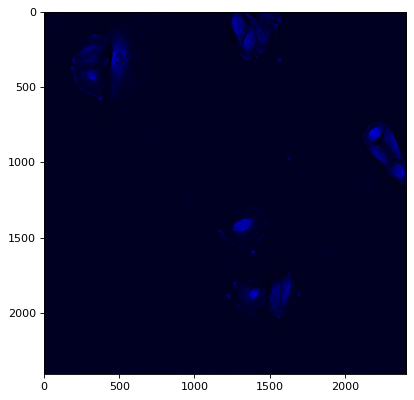

In [9]:
overlayed_img = overlay(
    test_img, test_mask, mask_channel_rgb_val=100, img_channel_rgb_val_factor=2
)
figure = plt.figure(figsize=(8, 6), dpi=80)

plt.imshow(overlayed_img)

## Segment all the cells

[10/14 02:59:42 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\dummy\Anaconda3\envs\cv-general\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 3/3 [00:10<00:00,  3.36s/it]

[WARN] more than 1 contour found in the instance mask


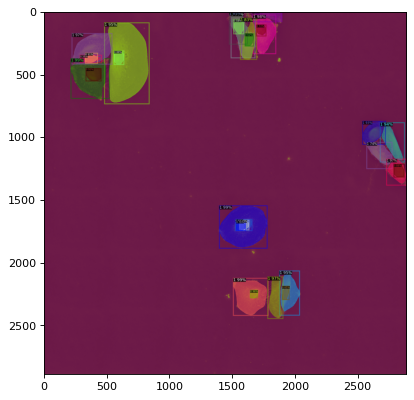

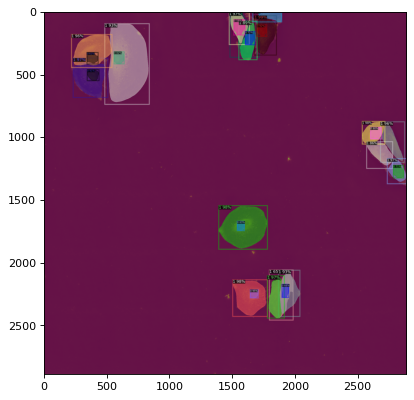

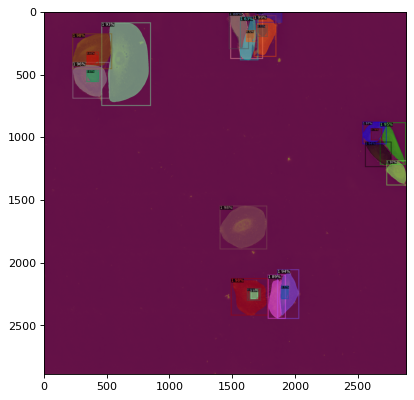

In [10]:
from livecell_tracker.segment.detectron_utils import convert_detectron_instance_pred_masks_to_binary_masks, convert_detectron_instances_to_label_masks, segment_images_by_detectron, segment_single_img_by_detectron_wrapper
segmentation_results = segment_images_by_detectron(imgs, DETECTRON_CFG, out_dir)


## Visualize segmentation by overlay movies

In [11]:
# segment_func = segment_cellpose_wrapper
# segment_func = segment_detectron_wrapper

# overlay_img_generator = ...
# overlay_img_generator = overlay
# overlay_img_generator = detectron_visualize_img

# def cellpose_segment_imgs(img, out_dir, frame, ndigits):
#     for idx in tqdm(range(len(imgs))):
#         img_path = imgs.get_img_path(idx)
#         img = imgs[idx]
#         file_name = os.path.basename(img_path)
#         output_filename = file_name.split(".")[0] + ".png" # change extension to PNG
#         mask = segment_func_wrapper(img)

#         # convert mask to 8-bit binary mask
#         assert mask.max() < 2**8, "more than 256 instances predicted?"
#         mask = mask.astype(np.uint8)
#         temp_img = Image.fromarray(mask)
#         temp_img.save(out_dir / output_filename)

#         overlay_output_filename = "overlay_" + file_name.split(".")[0] + ".png" # change extension to PNG
#         # overlayed_img = overlay(img, mask, mask_channel_rgb_val=100, img_channel_rgb_val_factor=2)
#         overlayed_img = detectron_visualize_img(img, DETECTRON_CFG, )
#         overlayed_img.save(out_dir / overlay_output_filename)

In [23]:
from livecell_tracker.segment.detectron_utils import (
    segment_detectron_wrapper,
    segment_images_by_detectron,
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
)


In [15]:
from livecell_tracker.core.datasets import LiveCellImageDataset
from livecell_tracker.segment.detectron_utils import detectron_visualize_img


Check result datastructure of detectron outputs

In [17]:
mask, results = segment_single_img_by_detectron_wrapper(imgs[0], DETECTRON_PREDICTOR,return_detectron_results=True)

In [18]:
pred_masks = results["instances"].to("cpu").pred_masks.numpy()
np.max(pred_masks)

True

In [19]:
results["instances"].get_fields().keys()

dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_masks'])

## Segment all the cells

[10/14 03:01:48 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

100%|██████████| 3/3 [00:10<00:00,  3.35s/it]

[WARN] more than 1 contour found in the instance mask


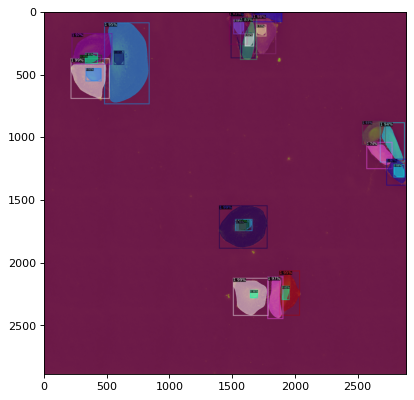

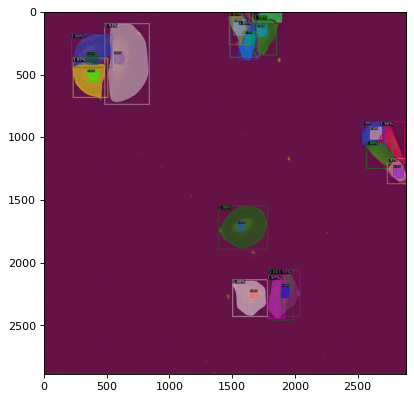

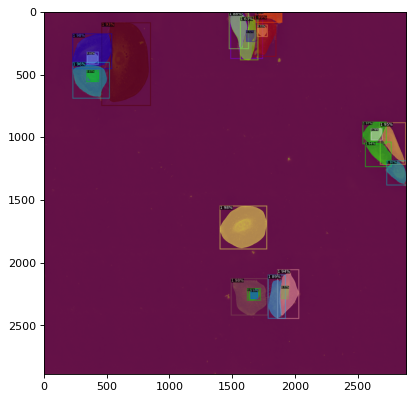

In [22]:
segmentation_results = segment_images_by_detectron(imgs,out_dir, cfg=DETECTRON_CFG)
with open(out_dir / "segmentation_results.json", "w") as f:
    json.dump(segmentation_results, f)

## Generate contour points

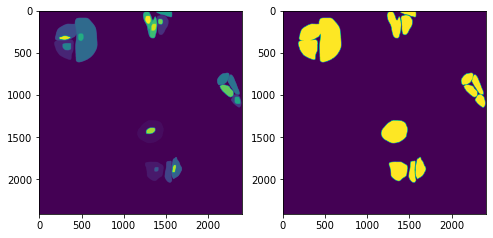

In [29]:
# for instance in results["instances"].to("cpu").pred_masks.numpy():
#     print(instance)
binary_mask = convert_detectron_instance_pred_masks_to_binary_masks(results["instances"].to("cpu").pred_masks.numpy())
label_mask = convert_detectron_instances_to_label_masks(results["instances"].to("cpu").pred_masks.numpy())
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(label_mask)
axes[1].imshow(binary_mask)

Find contours in label mask combined

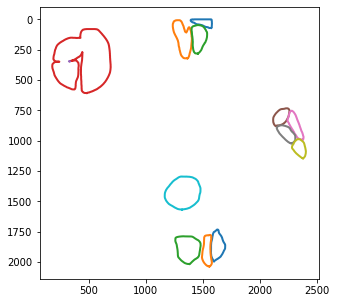

In [30]:
contours = measure.find_contours(
                label_mask, level=0.5, fully_connected="low", positive_orientation="low"
)

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()
ax.invert_yaxis()
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)


Find contours by instance prediction

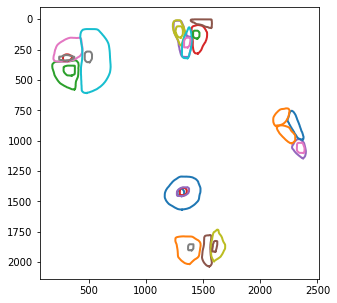

In [31]:
contours = []
for instance_mask in results["instances"].to("cpu").pred_masks.numpy():
    tmp_contours = measure.find_contours(
                instance_mask, level=0.5, fully_connected="low", positive_orientation="low")
    contours.append(tmp_contours[0])

# # Following code not correct
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()
ax.invert_yaxis()
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
